In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
data['SMA1'] = data[symbol].rolling(42).mean()

In [7]:
data['SMA2'] = data[symbol].rolling(258).mean()

<Axes: xlabel='Date'>

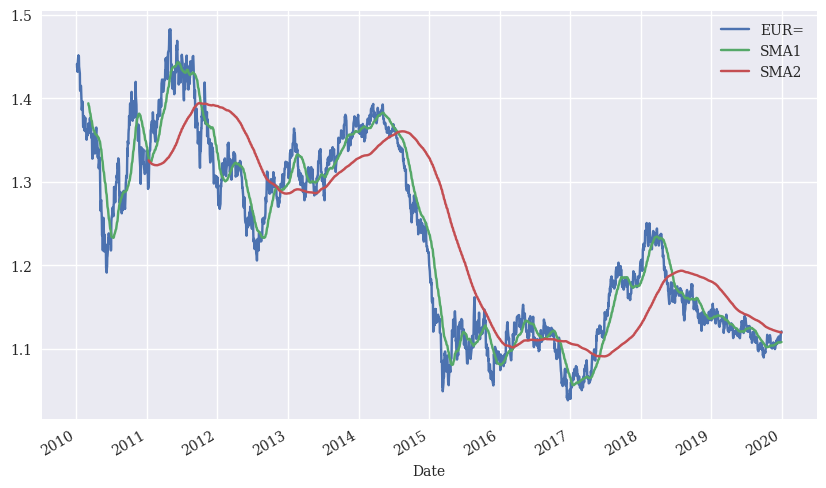

In [8]:
data.plot(figsize=(10, 6))

In [9]:
data.dropna(inplace=True)

In [10]:
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [11]:
data['p'] = data['p'].shift(1)

In [12]:
data.dropna(inplace=True)

<Axes: xlabel='Date'>

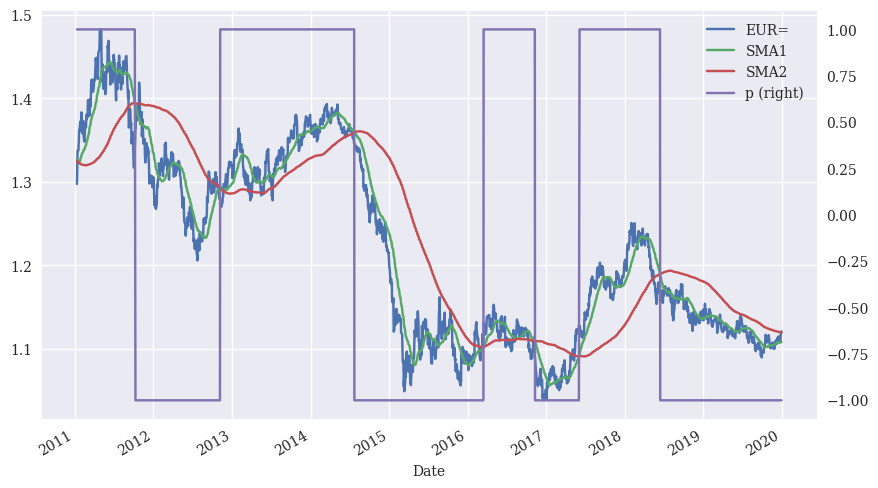

In [13]:
data.plot(figsize=(10, 6), secondary_y='p')

In [14]:
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [15]:
data.dropna(inplace=True)

In [16]:
data['s'] = data['p'] * data['r']

In [17]:
data[['r', 's']].sum().apply(np.exp)

r   0.8640
s   1.3773
dtype: float64

In [18]:
data[['r', 's']].sum().apply(np.exp) - 1

r   -0.1360
s    0.3773
dtype: float64

<Axes: xlabel='Date'>

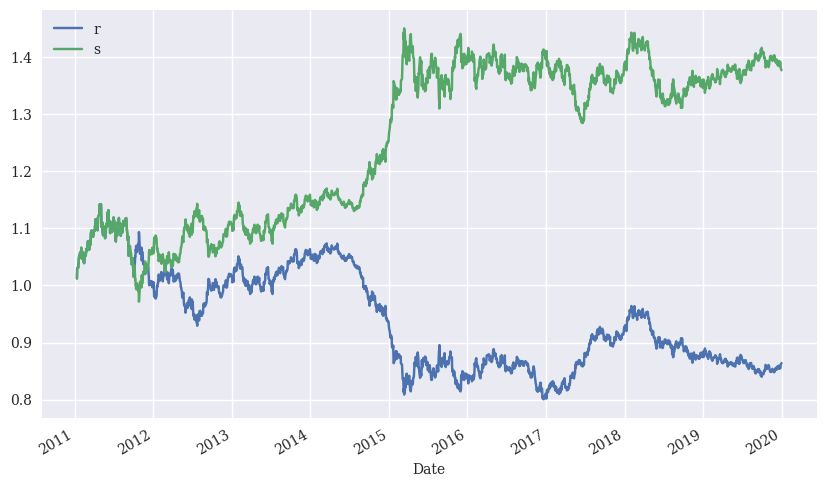

In [19]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [20]:
sum(data['p'].diff() != 0) + 2

10

In [21]:
pc = 0.005

In [22]:
data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])

In [23]:
data['s_'].iloc[0] -= pc

In [24]:
data['s_'].iloc[-1] -= pc

In [25]:
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.0123,0.0123,0.0023
2011-10-10,0.0198,-0.0198,-0.0248
2012-11-07,-0.0034,-0.0034,-0.0084
2014-07-24,-0.0001,0.0001,-0.0049
2016-03-16,0.0102,0.0102,0.0052
2016-11-10,-0.0018,0.0018,-0.0032
2017-06-05,-0.0025,-0.0025,-0.0075
2018-06-15,0.0035,-0.0035,-0.0085


In [26]:
data[['r', 's', 's_']].sum().apply(np.exp)

r    0.8640
s    1.3773
s_   1.3102
dtype: float64

In [28]:
data[['r', 's', 's_']].sum().apply(np.exp)

r    0.8640
s    1.3773
s_   1.3102
dtype: float64

<Axes: xlabel='Date'>

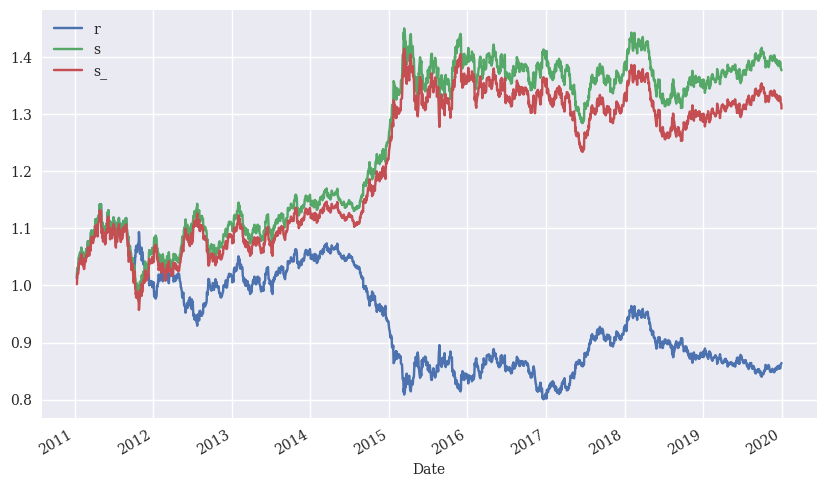

In [29]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [30]:
data[['r', 's', 's_']].std()

r    0.0054
s    0.0054
s_   0.0054
dtype: float64

In [31]:
data[['r', 's', 's_']].std() * math.sqrt(252)

r    0.0853
s    0.0853
s_   0.0855
dtype: float64

In [32]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [34]:
lags = 5

In [35]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']

    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [36]:
data, cols = add_lags(data, symbol, lags, window=20)

In [41]:
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score

In [42]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [43]:
set_seeds()

In [44]:
optimizer = Adam(learning_rate=0.0001)

In [45]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [77]:
split = '2018-01-01'

In [78]:
train = data.loc[:split].copy()

In [79]:
np.bincount(train['d'])

array([ 982, 1006])

In [80]:
mu, std = train.mean(), train.std()

In [81]:
train_ = (train - mu) / std

In [82]:
set_seeds()

In [159]:
model = create_model(hl=2, hu=64)

In [160]:
model.fit(train_[cols], train['d'],
          epochs=20, verbose=False,
          validation_split=0.2, shuffle=False)

In [161]:
model.evaluate(train_[cols], train['d'])

63/63 [==============================] - 0s 383us/step - loss: 0.6599 - accuracy: 0.6147


[0.6599389314651489, 0.6146881580352783]

In [162]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)

63/63 [==============================] - 0s 353us/step


In [163]:
train['p'] = np.where(train['p'] == 1, 1, -1)

In [164]:
train['p'].value_counts()

-1    1002
 1     986
Name: p, dtype: int64

In [165]:
train['s'] = train['p'] * train['r']

In [166]:
train[['r', 's']].sum().apply(np.exp)

r   0.8787
s   8.3621
dtype: float64

In [167]:
train[['r', 's']].sum().apply(np.exp) - 1

r   -0.1213
s    7.3621
dtype: float64

<Axes: xlabel='Date'>

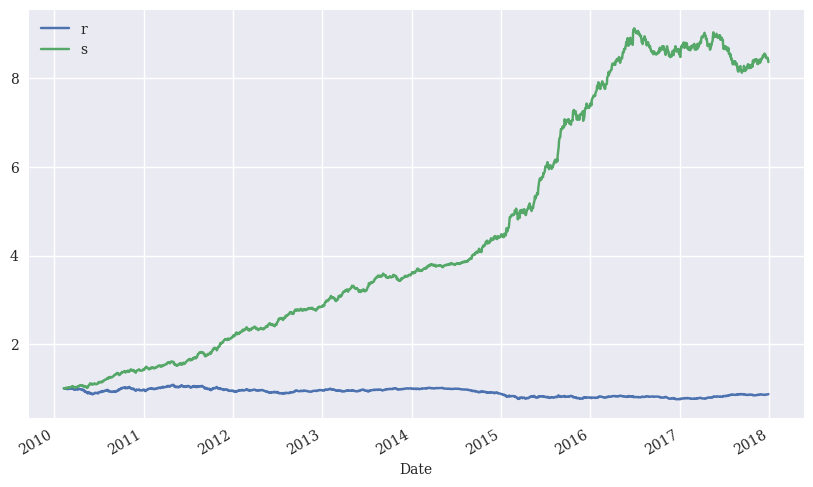

In [168]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [169]:
test = data.loc[split:].copy()

In [170]:
test_ = (test - mu) / std

In [171]:
model.evaluate(test_[cols], test['d'])

16/16 [==============================] - 0s 956us/step - loss: 0.6978 - accuracy: 0.5447


[0.6978151798248291, 0.544731616973877]

In [172]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

16/16 [==============================] - 0s 377us/step


In [173]:
test['p'].value_counts()

-1    422
 1     81
Name: p, dtype: int64

In [174]:
test['s'] = test['p'] * test['r']

In [175]:
test[['r', 's']].sum().apply(np.exp)

r   0.9345
s   1.2999
dtype: float64

In [176]:
test[['r', 's']].sum().apply(np.exp) - 1

r   -0.0655
s    0.2999
dtype: float64

<Axes: xlabel='Date'>

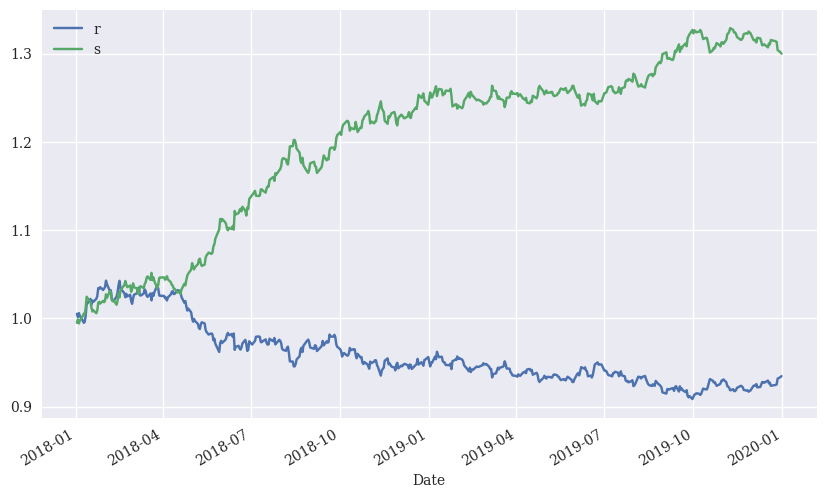

In [177]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [178]:
sum(test['p'].diff() != 0)

119

In [179]:
spread = 0.00012

In [180]:
pc = spread / data[symbol].mean()
pc

9.763870914257553e-05

In [181]:
test['s_'] = np.where(test['p'].diff() != 0, test['s'] - pc, test['s'])

In [182]:
test['s_'].iloc[0] -= pc

In [183]:
test['s_'].iloc[-1] -= pc

In [184]:
test[['r', 's', 's_']].sum().apply(np.exp)

r    0.9345
s    1.2999
s_   1.2846
dtype: float64

In [185]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.0655
s     0.2999
s_    0.2846
dtype: float64

<Axes: xlabel='Date'>

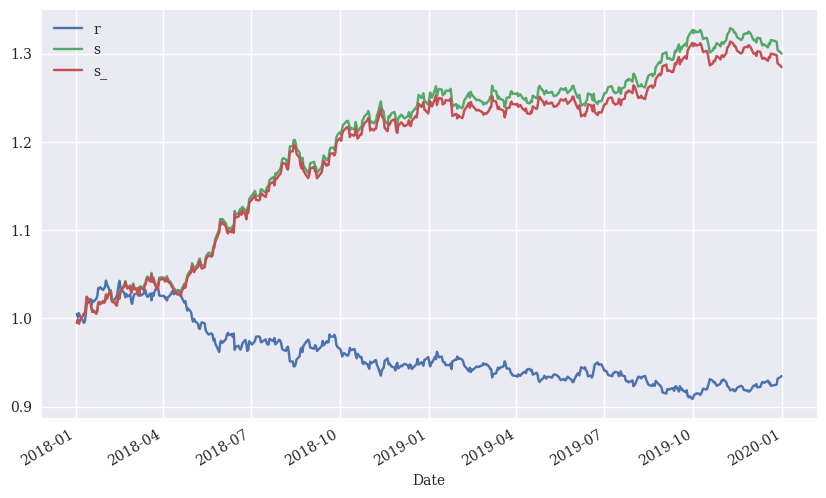

In [186]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [187]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [188]:
symbol = 'EUR='

In [192]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()['CLOSE'])
data.columns = [symbol]
data

,EUR=
Date,
2019-10-01 00:00:00,1.0899
2019-10-01 00:01:00,1.0898
2019-10-01 00:02:00,1.0896
2019-10-01 00:03:00,1.0898
2019-10-01 00:04:00,1.0898
...,...
2019-12-31 22:11:00,1.1211
2019-12-31 23:01:00,1.1211
2019-12-31 23:03:00,1.1211


In [194]:
data = data.resample('5min', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26486 entries, 2019-10-01 00:10:00 to 2019-12-31 23:15:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    26486 non-null  float64
dtypes: float64(1)
memory usage: 413.8 KB


In [195]:
lags = 5

In [196]:
data, cols = add_lags(data, symbol, lags, window=20)

In [197]:
split = int(len(data) * 0.85)

In [198]:
train = data.iloc[:split].copy()

In [199]:
np.bincount(train['d'])

array([16284,  6207])

In [200]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [201]:
mu, std = train.mean(), train.std()

In [202]:
train_ = (train - mu) / std

In [203]:
set_seeds()

In [204]:
model = create_model(hl=1, hu=128,
                     reg=True, dropout=False)

In [209]:
model.fit(train_[cols], train['d'],
          epochs=40, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 16.9 s, sys: 6.47 s, total: 23.4 s
Wall time: 15 s


In [210]:
model.evaluate(train_[cols], train['d'])

703/703 [==============================] - 0s 365us/step - loss: 0.5040 - accuracy: 0.7088


[0.5039886832237244, 0.7088168859481812]

In [211]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)

703/703 [==============================] - 0s 301us/step


In [212]:
train['p'].value_counts()

-1    12437
 1    10054
Name: p, dtype: int64

In [213]:
train['s'] = train['p'] * train['r']

In [214]:
train[['r', 's']].sum().apply(np.exp)

r   1.0223
s   1.9880
dtype: float64

In [215]:
train[['r', 's']].sum().apply(np.exp) - 1

r   0.0223
s   0.9880
dtype: float64

<Axes: xlabel='Date'>

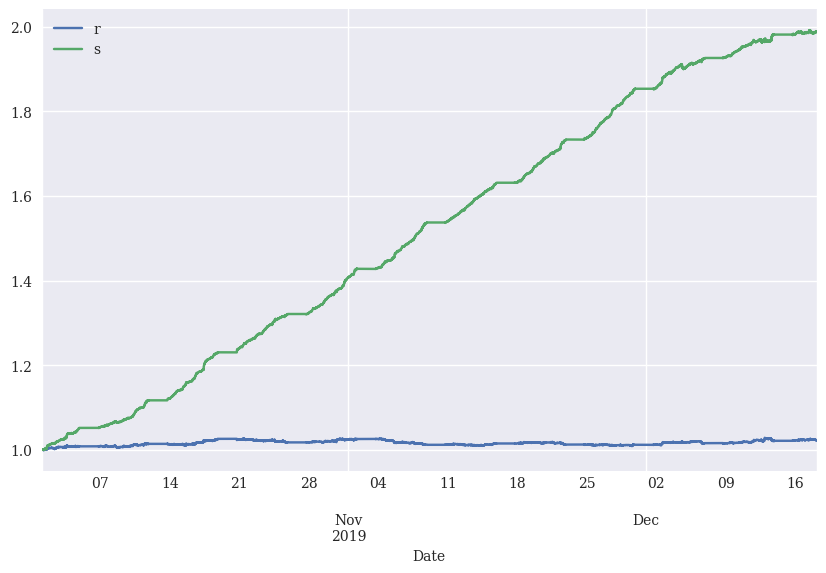

In [216]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [217]:
test = data.iloc[split:].copy()

In [218]:
test_ = (test - mu) / std

In [219]:
model.evaluate(test_[cols], test['d'])

125/125 [==============================] - 0s 401us/step - loss: 0.5340 - accuracy: 0.6831


[0.5339575409889221, 0.6831234097480774]

In [220]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

125/125 [==============================] - 0s 319us/step


In [221]:
test['p'].value_counts()

-1    2303
 1    1667
Name: p, dtype: int64

In [222]:
test['s'] = test['p'] * test['r']

In [223]:
test[['r', 's']].sum().apply(np.exp)

r   1.0071
s   1.0849
dtype: float64

In [224]:
test[['r', 's']].sum().apply(np.exp) - 1

r   0.0071
s   0.0849
dtype: float64

<Axes: xlabel='Date'>

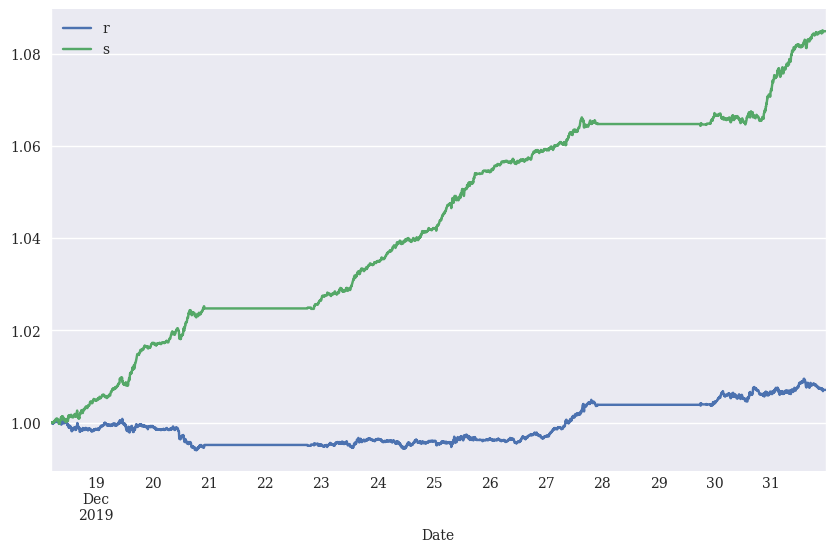

In [225]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [228]:
sum(test['p'].diff() != 0)

1317

In [229]:
spread = 0.00012

In [230]:
pc_1 = spread / test[symbol]

In [231]:
spread = 0.00006

In [232]:
pc_2 = spread / test[symbol]

In [233]:
test['s_1'] = np.where(test['p'].diff() != 0, test['s'] - pc_1, test['s'])

In [234]:
test['s_1'].iloc[0] -= pc_1.iloc[0]
test['s_1'].iloc[-1] -= pc_1.iloc[0]

In [235]:
test['s_2'] = np.where(test['p'].diff() != 0, test['s'] - pc_2, test['s'])

In [236]:
test['s_2'].iloc[0] -= pc_2.iloc[0]
test['s_2'].iloc[-1] -= pc_2.iloc[0]

In [237]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

r     1.0071
s     1.0849
s_1   0.9410
s_2   1.0104
dtype: float64

<Axes: xlabel='Date'>

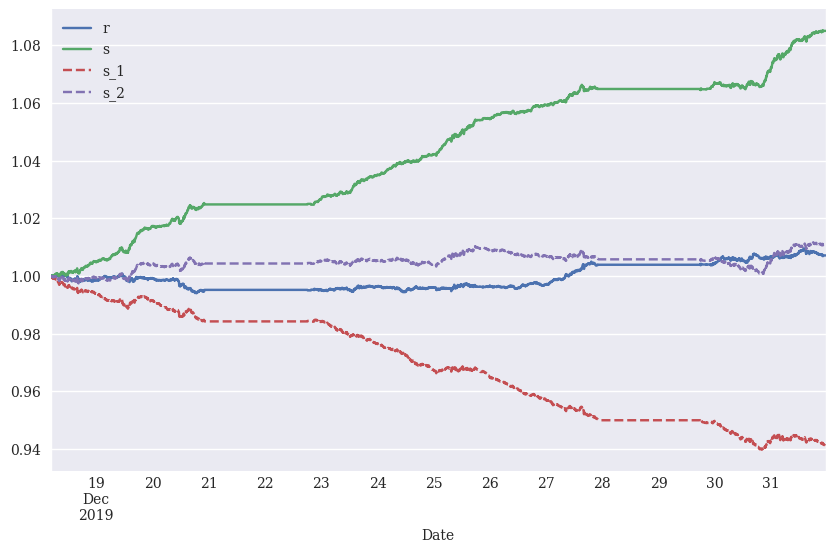

In [238]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(np.exp).plot(figsize=(10, 6), style=['-', '-', '--', '--'])